<a href="https://colab.research.google.com/github/VLCHS/FCNN-for-p_pi0/blob/FCNN/Training_FCNN_p_pi0%26logging_results_to_wandb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Getting Started

In [1]:
!pip install --q wandb
!pip install --q wandb[media]
!pip install --q torch==2.5.1
!pip install --q lightning==2.4.0
!pip install --q featuretools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.3/33.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 16.1 MB/s eta 0:00:00


In [2]:
# necessary code, if wandb doesn't want to login for no reason
import os
os.environ['WANDB_INIT_TIMEOUT'] = '300'
os.environ['WANDB_HTTP_TIMEOUT'] = '300'
os.environ["WANDB__SERVICE_WAIT"] = "300"
os.environ['WANDB_DEBUG'] = 'true'
os.environ['WANDB_CORE_DEBUG'] = 'true'

In [3]:
import os
import sys

import tqdm
import math
import wandb
wandb.require("legacy-service")

import torch
import pylab
import random
import logging
import torchmetrics

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import featuretools as ft

from scipy import spatial
from random import randint
from scipy.stats import chisquare, kstest
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError
from torchmetrics import MeanSquaredError
from torchmetrics import R2Score
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    pl.seed_everything(seed)

set_random_seed(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [4]:
device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [5]:
from google.colab import files
uploaded = files.upload()

Saving clasdb_pi_0_p.txt to clasdb_pi_0_p.txt


In [6]:
# Load the data Ebeam = [1.64 2.44 5.75 2.04]
df = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df['cos_phi'] = df['phi'].apply(lambda x: math.cos(x))
df['sin_phi'] = df['phi'].apply(lambda x: math.sin(x))
df['Ebeam'] = df['Ebeam'].round(decimals=2)
df = df.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
df = df[df['dsigma_dOmega'] <= df["dsigma_dOmega"].quantile(0.97)]
df = df[df['error'] <= df["error"].quantile(0.98)]
df = df.drop(df[df['dsigma_dOmega'] == 0].index)
df = df.drop('id', axis=1)
df = df.reset_index(drop=True)
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
df = df.reset_index(drop=True)
df

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,cos_phi,sin_phi
0,1.64,1.1000,0.40,-0.9,0.261799,0.912000,0.982353,0.965926,0.258819
1,1.64,1.1000,0.40,-0.9,0.785398,0.175000,0.356108,0.707107,0.707107
2,1.64,1.1000,0.40,-0.9,1.308997,1.650000,2.769879,0.258819,0.965926
3,1.64,1.1000,0.40,-0.9,1.832596,0.560000,0.979330,-0.258819,0.965926
4,1.64,1.1000,0.40,-0.9,2.356194,1.130000,0.909689,-0.707107,0.707107
...,...,...,...,...,...,...,...,...,...
72238,2.04,1.7875,0.65,0.9,4.581489,0.485355,0.093559,-0.130526,-0.991445
72239,2.04,1.7875,0.65,0.9,4.843289,0.528385,0.083915,0.130526,-0.991445
72240,2.04,1.7875,0.65,0.9,5.105088,0.497479,0.107885,0.382683,-0.923880
72241,2.04,1.7875,0.65,0.9,5.366887,2.774690,2.426200,0.608761,-0.793353


Text(0, 0.5, 'Q^2, GeV^2')

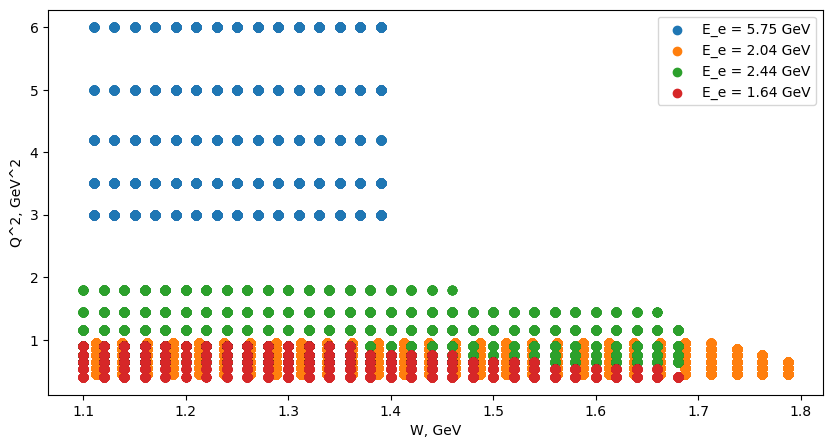

In [7]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(df[df.Ebeam==5.75].W, df[df.Ebeam==5.75].Q2, label='E_e = 5.75 GeV')
plt.scatter(df[df.Ebeam==2.04].W, df[df.Ebeam==2.04].Q2, label='E_e = 2.04 GeV')
plt.scatter(df[df.Ebeam==2.44].W, df[df.Ebeam==2.44].Q2, label='E_e = 2.44 GeV')
plt.scatter(df[df.Ebeam==1.64].W, df[df.Ebeam==1.64].Q2, label='E_e = 1.64 GeV')
plt.legend()
plt.xlabel('W, GeV')
plt.ylabel('Q^2, GeV^2')

#TRAINING

In [8]:
# Initialize wandb
wandb.init(entity='nucl_clas', project="FCNN for ep->ep_pi0, unified topology", name="5.1 Augmentation, factor=5")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [11]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = torch.sqrt(torch.mean((x - y)**2))
        return criterion

#params
project_name = "FCNN for ep->ep_pi0, unified topology"

logger_path = './wandb_local_logs'
data_path = '/content/clasdb_pi_0_p.txt'

hyperparams_dict = {
    'feature_engineering': False,
    'scale_data': True,
    'feature_scaler': MinMaxScaler(),
    'label_scaler': MinMaxScaler(),
    'augment': True,
    'augment_factor': 5,
    'test_size': 0.1,
    'batch_size': 256,
    'net_architecture': [6,60,80,100,120,140,240,340,440,640,2000,1040,640,340,
                         240,140,100,80,60,20,1],  #the 1st layer is 6 or 37
    'activation_function': nn.ReLU(), #nn.LeakyReLU(0.01),
    'loss_func': RMSELoss(),
    'optim_func': torch.optim.Adam,
    'max_epochs': 200,
    'es_min_delta': 1e-05,
    'es_patience': 50,
    'lr': 0.001,
    'lr_factor': 0.5,
    'lr_patience': 5,
    'lr_cooldown': 20,
}

wandb_logger = WandbLogger(project=project_name,
                           save_dir=logger_path)
exp_name = wandb_logger.experiment.name

logger_full_path = os.path.join(logger_path, project_name, exp_name)

os.makedirs(logger_full_path, exist_ok=True)
logging.basicConfig(encoding='utf-8',
                    level=logging.DEBUG,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                              logging.StreamHandler(sys.stdout)],
                    force=True)

class InterpolDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len

class InterpolDataModule(pl.LightningDataModule):
    def __init__(self, hyperparams):
        super().__init__()
        self.df = None
        self.hyperparams = hyperparams
        self.train_dataset = None
        self.val_dataset = None

    def augment(self, new_augm):
        augm_phi = np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi/30), 0, 2*np.pi)
        augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam/30),
                           'W': np.random.normal(loc=new_augm.W, scale=new_augm.W/30),
                           'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2/30),
                           'cos_theta': np.clip(np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta/30)), -1, 1),
                           'phi': augm_phi,
                           'cos_phi': math.cos(augm_phi),
                           'sin_phi': math.sin(augm_phi),
                           'dsigma_dOmega': np.random.normal(loc=new_augm.dsigma_dOmega, scale=new_augm.error/3),
                           'error': new_augm.error,
                           #'reaction_type': new_augm.reaction_type,
                          })
        return augm

    def feature_engineering(self, df):
        df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
        es = ft.EntitySet(id="data")
        es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

        # Run deep feature synthesis with transformation primitives
        feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                              trans_primitives = ['add_numeric', 'multiply_numeric'])

        df_after_feature_eng = feature_matrix.copy()
        #df_after_feature_eng['reaction_type'] = df['reaction_type']
        return df_after_feature_eng


    #DATA READING AND PREPROCESSING
    def setup(self, stage):
        # df for ep->ep_pi0, reaction_type=1
        # Ebeam = [1.64 2.44 5.75 2.04]
        df_p = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
        df_p.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        df_p['phi'] = df_p.phi.apply(lambda x: math.radians(x))
        df_p['cos_phi'] = df_p['phi'].apply(lambda x: math.cos(x))
        df_p['sin_phi'] = df_p['phi'].apply(lambda x: math.sin(x))
        df_p['Ebeam'] = df_p['Ebeam'].round(decimals=2)                              #PREPROCESSING
        df_p = df_p.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})                     #PREPROCESSING
        df_p = df_p[df_p['dsigma_dOmega'] <= df_p["dsigma_dOmega"].quantile(0.97)]   #PREPROCESSING
        df_p = df_p[df_p['error'] <= df_p["error"].quantile(0.98)]                   #PREPROCESSING
        df_p = df_p.drop(df_p[df_p['dsigma_dOmega'] == 0].index)                     #PREPROCESSING
        #df_p["reaction_type"] = 1
        df_p = df_p.drop('id', axis=1)
        df_p = df_p.reset_index(drop=True)
        df_p = df_p.iloc[df_p[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        df_p = df_p.reset_index(drop=True)
        df = df_p.copy()

        # # df for ep->en_pi+, reaction_type=0
        # df_n = pd.read_csv('/content/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
        # df_n.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        # df_n.loc[8314:65670, 'Ebeam'] = 5.754 # peculiarity of this dataset.
        # df_n['phi'] = df_n.phi.apply(lambda x: math.radians(x))
        # df_n['cos_phi'] = df_n['phi'].apply(lambda x: math.cos(x))
        # df_n['sin_phi'] = df_n['phi'].apply(lambda x: math.sin(x))
        # df_n = df_n[df_n['dsigma_dOmega'] <= df_n["dsigma_dOmega"].quantile(0.97)]
        # df_n = df_n[df_n['error'] <= df_n["error"].quantile(0.98)]
        # df_n = df_n.drop('id', axis=1)
        # df_n = df_n.reset_index(drop=True)
        # df_n = df_n.iloc[df_n[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        # df_n["reaction_type"] = 0
        # df_n = df_n.reset_index(drop=True)

        # # concat df_p and df_n into df
        # df = pd.concat([df_p, df_n], ignore_index=True)
        self.df = df

        feature_columns = list(df.columns)
        feature_columns.remove('dsigma_dOmega')
        feature_data = df[feature_columns]
        label_data = df['dsigma_dOmega']


        #TRAIN TEST SPLIT
        train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                  label_data,
                                                                                                  test_size=self.hyperparams.get('test_size'),
                                                                                                  random_state=42)


        # AUGMENTATION ON TRAIN DATA
        if self.hyperparams.get('augment'):
            train_df = pd.concat([train_feature_data, train_label_data], axis=1)
            aug_series_list = []
            for i in tqdm.tqdm(train_df.itertuples()):
                for _ in range(self.hyperparams.get('augment_factor')):
                    aug_series_list.append(self.augment(i))

            aug_df = pd.DataFrame(aug_series_list)
            augment_train_df = pd.concat([train_df, aug_df], ignore_index=True)
            train_label_data = augment_train_df["dsigma_dOmega"]
            train_feature_data = augment_train_df.loc[:, ~augment_train_df.columns.isin(["dsigma_dOmega"])]
        else:
            pass

        # DELETING PHI AND ERROR FROM FEATURES
        train_feature_data = train_feature_data.reset_index(drop=True)
        val_feature_data = val_feature_data.reset_index(drop=True)
        train_feature_data = train_feature_data.loc[:, ~train_feature_data.columns.isin(["phi", "error"])]
        val_feature_data = val_feature_data.loc[:, ~val_feature_data.columns.isin(["phi", "error"])]


        # FEATURE ENGINEERING
        if self.hyperparams.get('feature_engineering'):
            train_feature_data = self.feature_engineering(train_feature_data)
            val_feature_data = self.feature_engineering(val_feature_data)
        else:
            pass


        # SCALE DATA (FIT_TRANSFORM TRAIN AND TRANSFORM VAL)
        # DON'T SCALE REACTION_TYPE IN FEATURE DATASETS
        if self.hyperparams.get('scale_data'):
            #scale feature_data
            scaler_feature = self.hyperparams.get('feature_scaler')
            train_feature_data = train_feature_data.reset_index(drop=True)
            val_feature_data = val_feature_data.reset_index(drop=True)

            columns_to_scale = list(train_feature_data.columns)
            #columns_to_scale.remove("reaction_type")
            train_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.fit_transform(train_feature_data[columns_to_scale]))
            val_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.transform(val_feature_data[columns_to_scale]))

            #scale label_data
            scaler_target = self.hyperparams.get('label_scaler')
            train_label_data = pd.Series(scaler_target.fit_transform(train_label_data.to_frame())[:,0])
            val_label_data = pd.Series(scaler_target.transform(val_label_data.to_frame())[:,0])
        else:
            pass


        self.train_dataset = InterpolDataSet(torch.tensor(train_feature_data.values, dtype=torch.float32),
                                             torch.tensor(train_label_data.values, dtype=torch.float32))

        self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data.values, dtype=torch.float32),
                                           torch.tensor(val_label_data.values, dtype=torch.float32))


    def train_dataloader(self):
        return DataLoader(dataset = self.train_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(dataset = self.val_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=0)

class PrintCallbacks(Callback):
    def on_train_start(self, trainer, pl_module):
        logging.info("Training is starting")

    def on_train_end(self, trainer, pl_module):
        logging.info("Training is ending")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
        pl_module.training_step_outputs.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
        pl_module.validation_step_outputs.clear()

class InterpolRegressor(pl.LightningModule):
    def __init__(self, hyperparams):
        super(InterpolRegressor, self).__init__()

        self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0,0,0,0
        self.train_mse, self.val_mse = 0,0
        self.train_rmse, self.val_rmse = 0,0
        self.train_r2, self.val_r2 = 0,0
        self.hyperparams = hyperparams
        self.save_hyperparameters(self.hyperparams)

        self.mae = MeanAbsoluteError()
        self.mse = MeanSquaredError()
        self.rmse = self.mse ** 0.5
        self.r2 = R2Score()
        self.loss_func = self.hyperparams.get('loss_func')

        self.optim = self.hyperparams.get('optim_func')

        self.net_architecture = self.hyperparams.get('net_architecture')
        self.activation_function = self.hyperparams.get('activation_function')

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.net = nn.Sequential()
        for i in range(1,len(self.net_architecture)):
            self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
            if i!=len(self.net_architecture)-1:
                self.net.append(self.activation_function)
            else:
                pass

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.train_loss = loss.forward(y_hat.reshape(-1), y)
        self.train_mae = self.mae(y_hat.reshape(-1), y)
        self.train_mse = self.mse(y_hat.reshape(-1), y)
        self.train_rmse = self.rmse(y_hat.reshape(-1), y)
        self.train_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mse', self.train_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_rmse', self.train_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_r2', self.train_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.training_step_outputs.append(self.train_loss)
        return self.train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.val_loss = loss.forward(y_hat.reshape(-1), y)
        self.val_mae = self.mae(y_hat.reshape(-1), y)
        self.val_mse = self.mse(y_hat.reshape(-1), y)
        self.val_rmse = self.rmse(y_hat.reshape(-1), y)
        self.val_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mse', self.val_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_rmse', self.val_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_r2', self.val_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.validation_step_outputs.append(self.val_loss)
        return self.val_loss

    def on_validation_epoch_end(self):
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch!=0:
                sch.step(self.trainer.callback_metrics["val_loss"])

    def configure_callbacks(self):
        early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                            min_delta=self.hyperparams.get('es_min_delta'),
                                            patience=self.hyperparams.get('es_patience'),
                                            verbose=True)

        checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                              monitor="val_loss",
                                              mode="min",
                                              dirpath=f"{logger_full_path}/checkpoints",
                                              filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

        lr_monitor = LearningRateMonitor(logging_interval='epoch')

        print_callback = PrintCallbacks()

        return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
        lr_optim = ReduceLROnPlateau(optimizer = optimizer,
                                     mode = 'min',
                                     factor = self.hyperparams.get('lr_factor'),
                                     patience = self.hyperparams.get('lr_patience'),
                                     cooldown=self.hyperparams.get('lr_cooldown'),
                                     threshold=0.01,
                                     verbose= True)
        return {"optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": lr_optim,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 2,
                    "name": 'lr_scheduler_monitoring'}
                }

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


In [12]:
data_module = InterpolDataModule(hyperparams=hyperparams_dict)
model = InterpolRegressor(hyperparams=hyperparams_dict)

trainer = pl.Trainer(max_epochs=hyperparams_dict.get('max_epochs'),
                     num_sanity_val_steps=0,
                     accelerator=device,
                     logger=wandb_logger,
                     enable_progress_bar=False)
trainer.fit(model, data_module)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
INFO: GPU available: False, used: False


2025-01-02 10:34:25,989 : INFO : GPU available: False, used: False


INFO: TPU available: False, using: 0 TPU cores


2025-01-02 10:34:25,995 : INFO : TPU available: False, using: 0 TPU cores


INFO: HPU available: False, using: 0 HPUs


2025-01-02 10:34:25,999 : INFO : HPU available: False, using: 0 HPUs


INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


2025-01-02 10:34:26,006 : INFO : The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


65018it [01:03, 1023.02it/s]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/5.1 Augmentation, factor=5/checkpoints exists and is not empty.
INFO: 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | RMSELoss            | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params

2025-01-02 10:36:01,991 : INFO : 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | RMSELoss            | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode
2025-01-02 10:36:02,029 : INFO : Training is starting
2025-01-02 10:42:56,948 : INFO : epoch: 0; val_loss: 0.06659812480211258
2025

INFO: Metric val_loss improved. New best score: 0.067


2025-01-02 10:42:57,087 : INFO : Metric val_loss improved. New best score: 0.067
2025-01-02 10:42:57,250 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/5.1 Augmentation, factor=5/checkpoints/exp_name=0val_loss=0.06660-epoch=00.ckpt
2025-01-02 10:50:25,544 : INFO : epoch: 1; val_loss: 0.061351627111434937
2025-01-02 10:50:25,556 : INFO : epoch: 1; train_loss: 0.08792170137166977


INFO: Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 0.061


2025-01-02 10:50:25,661 : INFO : Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 0.061
2025-01-02 10:50:25,792 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/5.1 Augmentation, factor=5/checkpoints/exp_name=0val_loss=0.06135-epoch=01.ckpt
2025-01-02 10:57:54,843 : INFO : epoch: 2; val_loss: 0.06596407294273376
2025-01-02 10:57:54,857 : INFO : epoch: 2; train_loss: 0.08705303072929382
2025-01-02 10:57:55,234 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/5.1 Augmentation, factor=5/checkpoints/exp_name=0val_loss=0.06596-epoch=02.ckpt
2025-01-02 11:05:25,858 : INFO : epoch: 3; val_loss: 0.05561145395040512
2025-01-02 11:05:25,868 : INFO : epoch: 3; train_loss: 0.08567821234464645


INFO: Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.056


2025-01-02 11:05:25,962 : INFO : Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.056
2025-01-02 11:05:26,090 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/5.1 Augmentation, factor=5/checkpoints/exp_name=0val_loss=0.05561-epoch=03.ckpt
2025-01-02 11:13:01,294 : INFO : epoch: 4; val_loss: 0.06085716933012009
2025-01-02 11:13:01,308 : INFO : epoch: 4; train_loss: 0.08355453610420227
2025-01-02 11:13:01,564 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/5.1 Augmentation, factor=5/checkpoints/exp_name=0val_loss=0.06086-epoch=04.ckpt
2025-01-02 11:20:36,042 : INFO : epoch: 5; val_loss: 0.05528417229652405
2025-01-02 11:20:36,055 : INFO : epoch: 5; train_loss: 0.0828222706913948


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.055


2025-01-02 11:20:36,162 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.055
2025-01-02 11:20:36,281 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/5.1 Augmentation, factor=5/checkpoints/exp_name=0val_loss=0.05528-epoch=05.ckpt
2025-01-02 11:28:15,664 : INFO : epoch: 6; val_loss: 0.055064257234334946
2025-01-02 11:28:15,676 : INFO : epoch: 6; train_loss: 0.0826651081442833


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.055


2025-01-02 11:28:15,781 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.055
2025-01-02 11:28:15,933 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/5.1 Augmentation, factor=5/checkpoints/exp_name=0val_loss=0.05506-epoch=06.ckpt
2025-01-02 11:35:56,645 : INFO : epoch: 7; val_loss: 0.05531059578061104
2025-01-02 11:35:56,662 : INFO : epoch: 7; train_loss: 0.08253377676010132
2025-01-02 11:35:56,931 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/5.1 Augmentation, factor=5/checkpoints/exp_name=0val_loss=0.05531-epoch=07.ckpt
2025-01-02 11:43:34,969 : INFO : epoch: 8; val_loss: 0.05940517783164978
2025-01-02 11:43:34,982 : INFO : epoch: 8; train_loss: 0.0815633237361908
2025-01-02 11:51:15,039 : INFO : epoch: 9; val_loss: 0.056704457849264145
2025-01-02 11:51:15,054 : INFO : epoch: 9; train_loss: 0.08149749040603638
2025-01-02 11:58:55,207 : INFO : epoch: 10; val_loss: 0.05501359328

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.055


2025-01-02 11:58:55,347 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.055
2025-01-02 11:58:55,483 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/5.1 Augmentation, factor=5/checkpoints/exp_name=0val_loss=0.05501-epoch=10.ckpt
2025-01-02 12:06:48,997 : INFO : epoch: 11; val_loss: 0.05448039993643761
2025-01-02 12:06:49,020 : INFO : epoch: 11; train_loss: 0.08135637640953064


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.054


2025-01-02 12:06:49,190 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.054
2025-01-02 12:06:49,425 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/5.1 Augmentation, factor=5/checkpoints/exp_name=0val_loss=0.05448-epoch=11.ckpt
2025-01-02 12:14:43,175 : INFO : epoch: 12; val_loss: 0.0545487105846405
2025-01-02 12:14:43,188 : INFO : epoch: 12; train_loss: 0.08130698651075363
2025-01-02 12:14:43,450 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/5.1 Augmentation, factor=5/checkpoints/exp_name=0val_loss=0.05455-epoch=12.ckpt
2025-01-02 12:22:53,539 : INFO : epoch: 13; val_loss: 0.05561380460858345
2025-01-02 12:22:53,551 : INFO : epoch: 13; train_loss: 0.0812683030962944
2025-01-02 12:31:00,041 : INFO : epoch: 14; val_loss: 0.05408606678247452
2025-01-02 12:31:00,053 : INFO : epoch: 14; train_loss: 0.08114520460367203


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.054


2025-01-02 12:31:00,166 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.054
2025-01-02 12:31:00,307 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/5.1 Augmentation, factor=5/checkpoints/exp_name=0val_loss=0.05409-epoch=14.ckpt
2025-01-02 12:39:09,666 : INFO : epoch: 15; val_loss: 0.055253297090530396
2025-01-02 12:39:09,682 : INFO : epoch: 15; train_loss: 0.08114854246377945
2025-01-02 12:47:24,572 : INFO : epoch: 16; val_loss: 0.05548382177948952
2025-01-02 12:47:24,589 : INFO : epoch: 16; train_loss: 0.08110591769218445
2025-01-02 12:55:47,045 : INFO : epoch: 17; val_loss: 0.053614336997270584
2025-01-02 12:55:47,058 : INFO : epoch: 17; train_loss: 0.08104784786701202


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.054


2025-01-02 12:55:47,165 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.054
2025-01-02 12:55:47,309 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/5.1 Augmentation, factor=5/checkpoints/exp_name=0val_loss=0.05361-epoch=17.ckpt
2025-01-02 13:04:20,824 : INFO : epoch: 18; val_loss: 0.05675910413265228
2025-01-02 13:04:20,836 : INFO : epoch: 18; train_loss: 0.08096317201852798
2025-01-02 13:13:03,046 : INFO : epoch: 19; val_loss: 0.053973518311977386
2025-01-02 13:13:03,057 : INFO : epoch: 19; train_loss: 0.0808739960193634
2025-01-02 13:13:03,296 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/5.1 Augmentation, factor=5/checkpoints/exp_name=0val_loss=0.05397-epoch=19.ckpt
2025-01-02 13:21:47,063 : INFO : epoch: 20; val_loss: 0.0544518381357193
2025-01-02 13:21:47,076 : INFO : epoch: 20; train_loss: 0.08094222098588943
2025-01-02 13:30:35,888 : INFO : epoch: 21; val_loss: 0.052156

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.052


2025-01-02 13:30:36,008 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.052
2025-01-02 13:30:36,133 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/5.1 Augmentation, factor=5/checkpoints/exp_name=0val_loss=0.05216-epoch=21.ckpt
2025-01-02 13:39:34,952 : INFO : epoch: 22; val_loss: 0.0531686507165432
2025-01-02 13:39:34,965 : INFO : epoch: 22; train_loss: 0.08084002137184143
2025-01-02 13:39:35,221 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/5.1 Augmentation, factor=5/checkpoints/exp_name=0val_loss=0.05317-epoch=22.ckpt
2025-01-02 13:48:37,747 : INFO : epoch: 23; val_loss: 0.0542580708861351
2025-01-02 13:48:37,758 : INFO : epoch: 23; train_loss: 0.0807657539844513
2025-01-02 13:57:44,975 : INFO : epoch: 24; val_loss: 0.052851151674985886
2025-01-02 13:57:44,988 : INFO : epoch: 24; train_loss: 0.08082059025764465
2025-01-02 13:57:45,235 : DEBUG : open file: /content/wandb_loc

INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...


2025-01-02 18:56:12,732 : INFO : 
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

# PLOT CROSS SECTIONS & STRUCTURE FUNCTIONS

In [13]:
model.eval()

# generate grid
def generate_grid_df(Ebeam):
    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
            for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)
    df_grid['cos_phi'] = df_grid['phi'].apply(lambda x: math.cos(x))
    df_grid['sin_phi'] = df_grid['phi'].apply(lambda x: math.sin(x))

    # feature engineering
    if model.hyperparams.get('feature_engineering'):
        def feature_engineering(df):
                df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
                es = ft.EntitySet(id="data")
                es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

                # Run deep feature synthesis with transformation primitives
                feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                                      trans_primitives = ['add_numeric', 'multiply_numeric'])

                df_after_feature_eng = feature_matrix.copy()
                #df_after_feature_eng['reaction_type'] = df['reaction_type']
                return df_after_feature_eng

        df_grid_for_prediction = feature_engineering(df_grid)
    else:
        df_grid_for_prediction = df_grid.loc[:, ~df_grid.columns.isin(["phi", "error"])]

    #scale feature data
    if model.hyperparams.get('scale_data'):
        scaler_feature = model.hyperparams.get('feature_scaler')
        columns_to_scale = list(df_grid_for_prediction.columns)
        #columns_to_scale.remove("reaction_type")
        df_grid_for_prediction[columns_to_scale] = pd.DataFrame(scaler_feature.transform(df_grid_for_prediction[columns_to_scale]))
    else:
        pass

    # predict crosssections
    df_grid_parts = np.array_split(df_grid_for_prediction, 100)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        dsigma_dOmega_predicted = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

        df_grid_part['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
        #df_grid_part.dsigma_dOmega_predicted = abs(df_grid_part.dsigma_dOmega_predicted)
        df_grid_parts_preds.append(df_grid_part)

    df_grid_for_prediction = pd.concat(df_grid_parts_preds)
    df_grid['dsigma_dOmega_predicted'] = df_grid_for_prediction["dsigma_dOmega_predicted"]
    del(df_grid_for_prediction)
    df_grid['A'] = 0
    df_grid['B'] = 0
    df_grid['C'] = 0

    if model.hyperparams.get('scale_data'):
        scaler_target = model.hyperparams.get('label_scaler')
        df_grid['dsigma_dOmega_predicted'] = pd.Series(scaler_target.inverse_transform(df_grid["dsigma_dOmega_predicted"].to_frame())[:,0])
    else:
        pass

    # calculate structure functions
    phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
    phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

    for i in tqdm.tqdm(range(len(phi_min_index))):
        cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
        cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
        cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)

        trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
        trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
        trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)

        A = trapz_A/(2*np.pi)
        B = trapz_B/(np.pi)
        C = trapz_C/(np.pi)

        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

    df_grid['dsigma_dOmega_sf'] = df_grid['A'] + df_grid['B']*np.cos(2*df_grid['phi']) + df_grid['C']*np.cos(df_grid['phi'])
    return df_grid

# drawing
def find_closest(df_for_search, W_for_search, Q2_for_search):
    global closest_index
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin()
    assert isinstance(closest_index, tuple([int, np.int64]))
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])

def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                         #(df.error < 1.5)&      # delete large errors of real data
                         (df.W == W_df)&
                         (df.Q2 == Q2_df)&
                         (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')

    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted

    xdata_preds_sf = xdata_preds
    ydata_preds_sf = df_grid_instance_set.dsigma_dOmega_sf

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]

    # recovered

    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]

    df_fitted = pd.DataFrame({'phi_fitted': xdata_fitted,
                              'dsigma_dOmega_fitted': ydata_fitted})

    df_chi_2 = pd.merge_asof(df_instance_set, df_fitted, left_on='phi', right_on='phi_fitted')
    df_chi_2 = pd.merge_asof(df_chi_2, df_grid_instance_set, on='phi')
    df_chi_2 = df_chi_2[['phi', 'dsigma_dOmega', 'dsigma_dOmega_fitted', 'dsigma_dOmega_predicted', 'dsigma_dOmega_sf']]

    real = df_chi_2['dsigma_dOmega'].apply(lambda x: np.round(x, 6)).values
    fitted = df_chi_2['dsigma_dOmega_fitted'].apply(lambda x: np.round(x, 6)).values
    preds = df_chi_2['dsigma_dOmega_predicted'].apply(lambda x: np.round(x, 6)).values
    preds_sf = df_chi_2['dsigma_dOmega_sf'].apply(lambda x: np.round(x, 6)).values

    stat_fitted_chi, p_value_fitted_chi = np.round(chisquare(real, np.sum(real)/np.sum(fitted)*fitted), 3)
    stat_preds_chi, p_value_preds_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds)*preds), 3)
    stat_preds_sf_chi, p_value_preds_sf_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds_sf)*preds_sf), 3)

    plt.figure(figsize=(22, 6), dpi=80)

    plt.figtext(0.13, 0.83, f'Params (exp, preds). W({W_df},{W_df_grid}); Q2({Q2_df},{Q2_df_grid})')

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Fitted data'
             #label=f'Fitted data, chi^2 = {stat_fitted_chi}, p_value = {p_value_fitted_chi}'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data'
             #label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )

    plt.plot(xdata_preds_sf,
             ydata_preds_sf,
             color='black',
             label=f'Predictions and recovered data'
             #label=f'Predictions and recovered data, chi^2 = {stat_preds_sf_chi}, p_value = {p_value_preds_sf_chi}'
             )

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma_dOmega: microbarn/sterad", fontsize="20")

    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

def fit_to_func(x):
    try:
        popt, pcov = curve_fit(func_cos, x.phi, x.dsigma_dOmega, sigma=x.error, absolute_sigma=True)
        a, b, c = popt[0], popt[1], popt[2]

        a_error, b_error, c_error = np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1]), np.sqrt(pcov[2][2])

        return a, b, c, a_error, b_error, c_error
    except Exception as e:
        return None, None, None, None, None, None

def generate_df_sf(Ebeam):
    df_sf = df.groupby(['Ebeam', 'W', 'Q2', 'cos_theta']).apply(lambda x: fit_to_func(x)).reset_index()

    df_sf['A'] = df_sf[0].apply(lambda x: x[0])
    df_sf['B'] = df_sf[0].apply(lambda x: x[1])
    df_sf['C'] = df_sf[0].apply(lambda x: x[2])

    df_sf['A_error'] = df_sf[0].apply(lambda x: x[3])
    df_sf['B_error'] = df_sf[0].apply(lambda x: x[4])
    df_sf['C_error'] = df_sf[0].apply(lambda x: x[5])

    df_sf.drop(0, axis=1, inplace=True)
    df_sf.dropna(inplace=True)
    df_sf = df_sf[(df_sf["A_error"] < 3) & (df_sf["B_error"] < 3) & (df_sf["C_error"] < 3)]
    return df_sf

def plot_joint_sf(df, E_beam, Q2, cos_theta, df_grid, func, func_error):

    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.Q2 == Q2)&
                        (df.cos_theta == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid_instance_set[(df_grid_instance_set['W']>=df_instance_set.W.min() - 0.2)&
                                                (df_grid_instance_set['W']<=df_instance_set.W.max() + 0.2)]

    if len(df_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    xdata_real = df_instance_set.W
    ydata_real = df_instance_set[func]
    ydata_real_error = df_instance_set[func_error]

    xdata_preds = df_grid_instance_set.W
    ydata_preds = df_grid_instance_set[func]

    plt.figure(figsize=(22, 6), dpi=80)

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_real_error,
                 color='red',
                 fmt='o')

    plt.scatter(x=xdata_preds,
                y=ydata_preds,
                color='black', marker='^', label=f"AI prediction")

    plt.xlabel("W: GeV", fontsize="20")
    plt.ylabel(f"{func}: microbarn/sterad", fontsize="20")
    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/{func}_E_beam={E_beam}_Q2={Q2}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

In [14]:
df_for_plot = pd.DataFrame({
      'Ebeam': [1.64, 1.64, 2.04, 2.04, 2.44, 2.44, 5.75, 5.75],
      'W': [1.12, 1.48, 1.12, 1.12, 1.14, 1.56, 1.14, 1.32],
      'Q2': [0.65, 0.4, 0.95, 0.45, 0.9, 1.15, 3.0, 5.0],
      'cos_theta': [0.3, -0.1, -0.5, 0.5, 0.1, 0.1, -0.5, 0.1]
})
df_for_plot

,Ebeam,W,Q2,cos_theta
0,1.64,1.12,0.65,0.3
1,1.64,1.48,0.40,-0.1
2,2.04,1.12,0.95,-0.5
3,2.04,1.12,0.45,0.5
4,2.44,1.14,0.90,0.1
5,2.44,1.56,1.15,0.1
6,5.75,1.14,3.00,-0.5
7,5.75,1.32,5.00,0.1


100%|██████████| 157/157 [00:08<00:00, 18.33it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-13-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.3708701169493434' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-13-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.032242884300819855' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

2025-01-02 19:09:49,781 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
2025-01-02 19:09:49,785 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-01-02 19:09:49,787 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-01-02 19:09:49,795 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-01-02 19:09:49,802 : DEBUG : findfont: score(Font

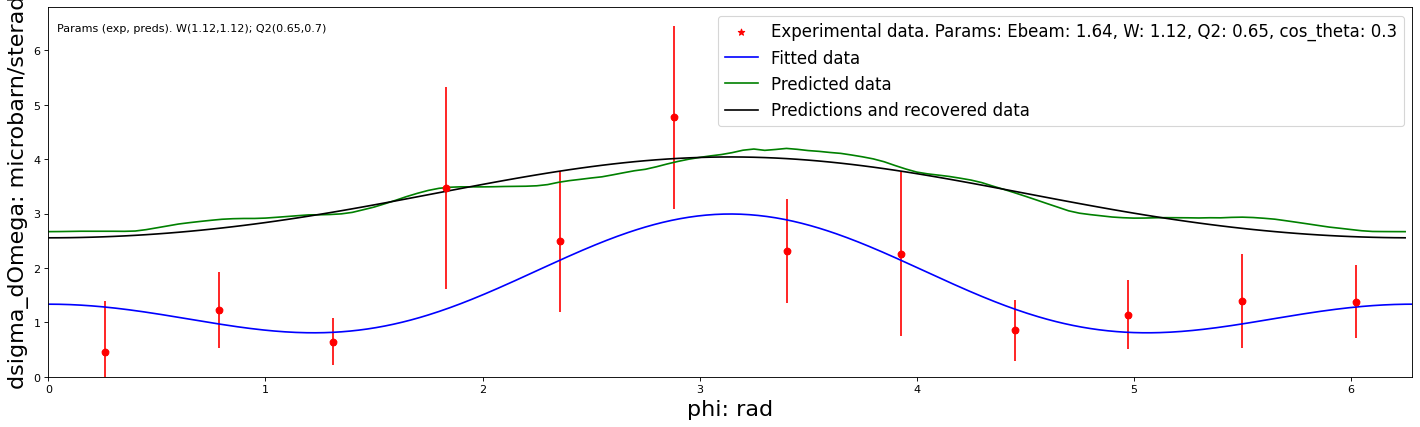

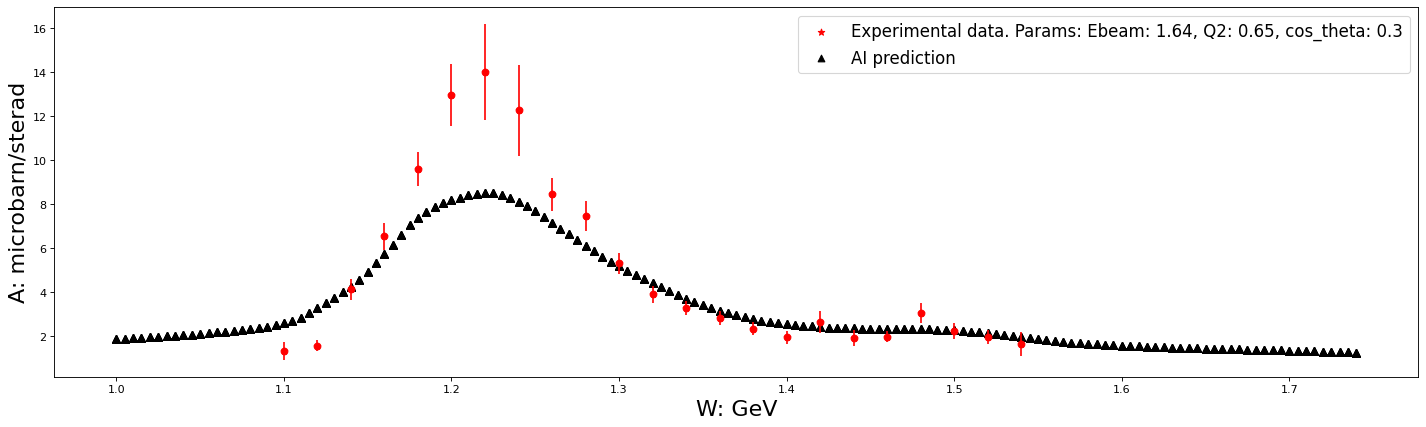

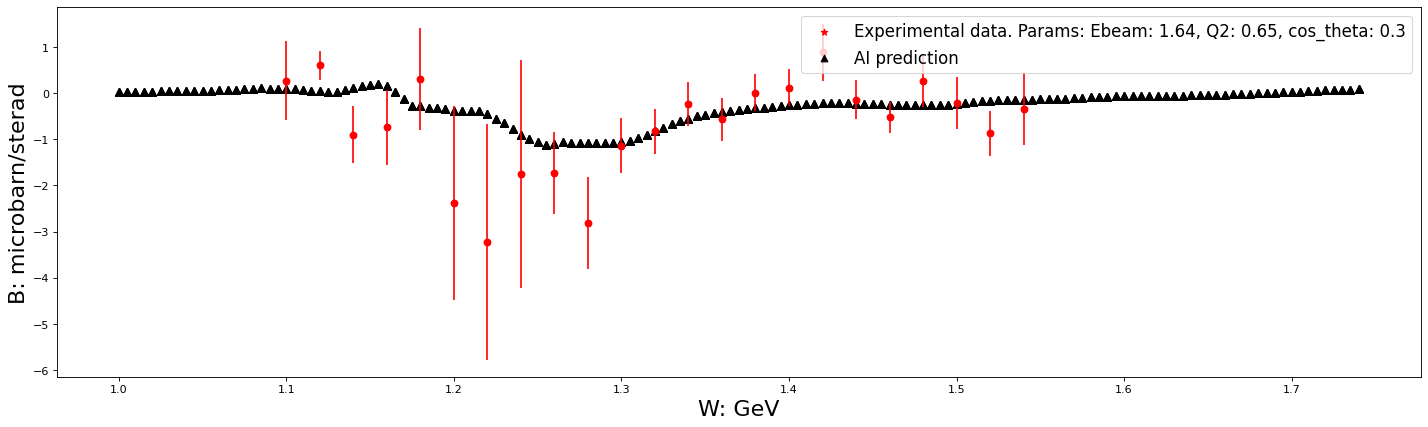

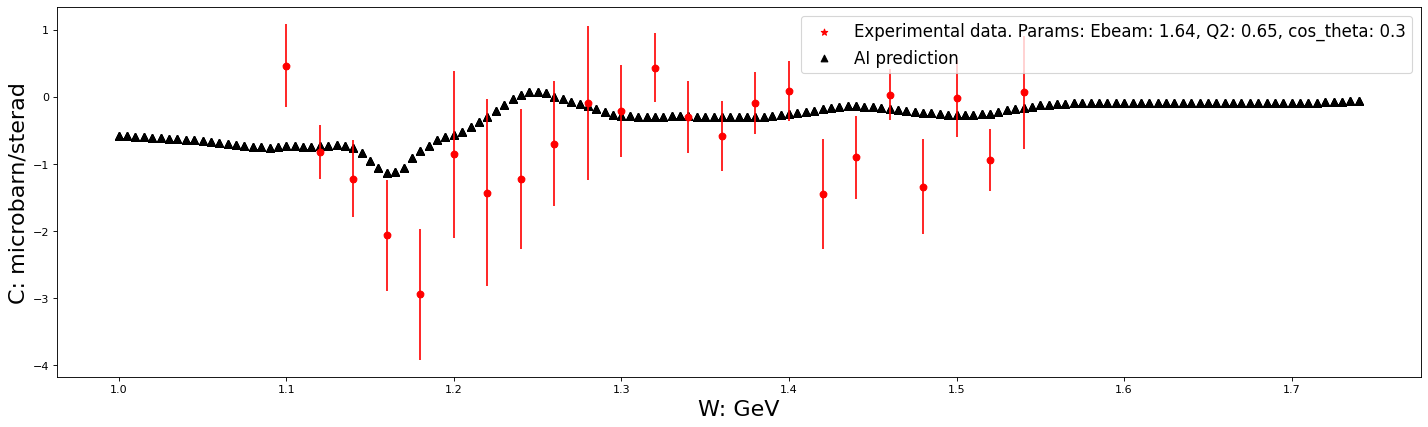

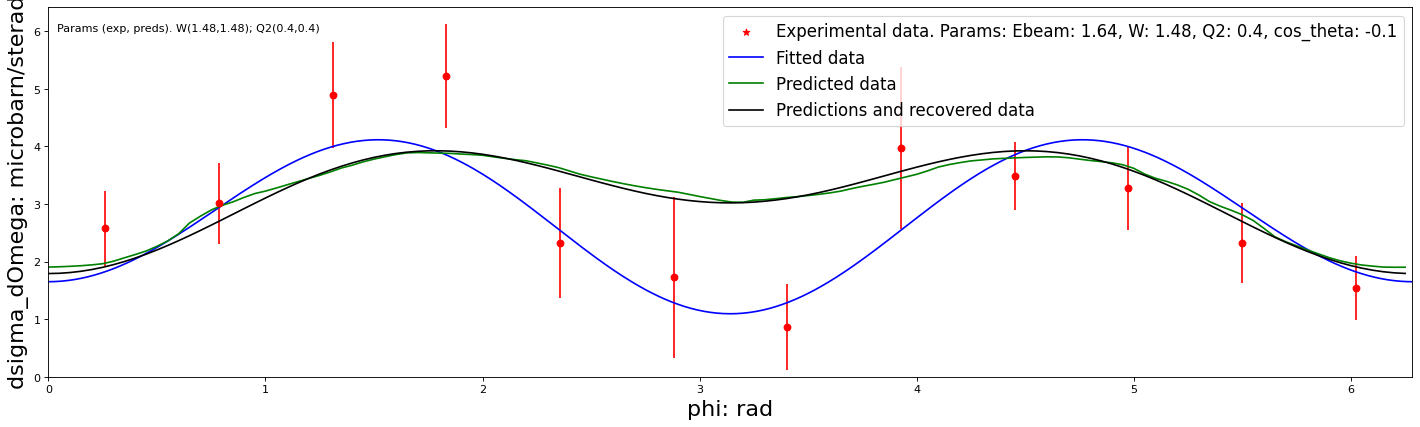

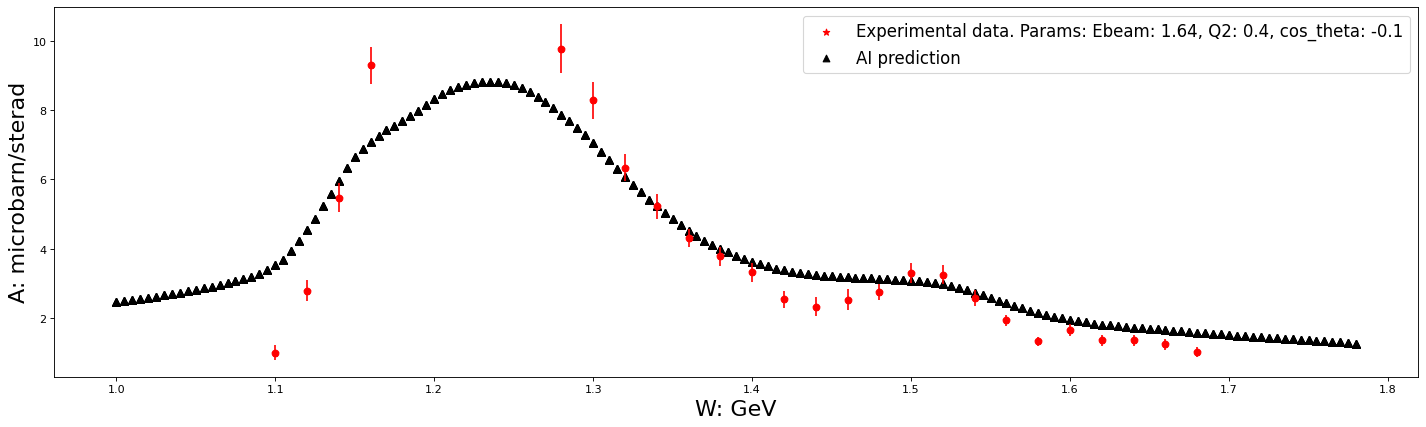

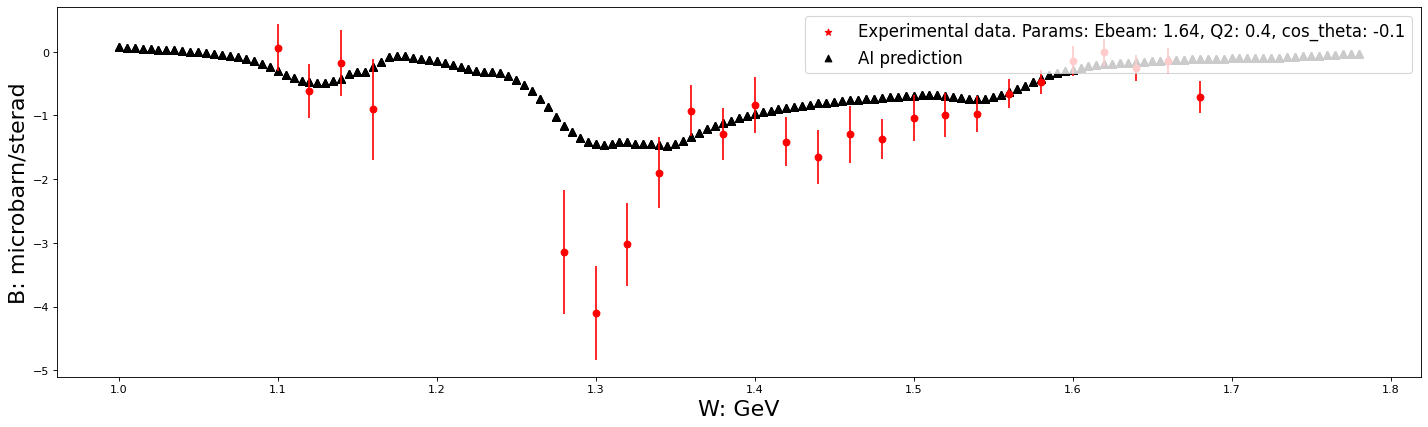

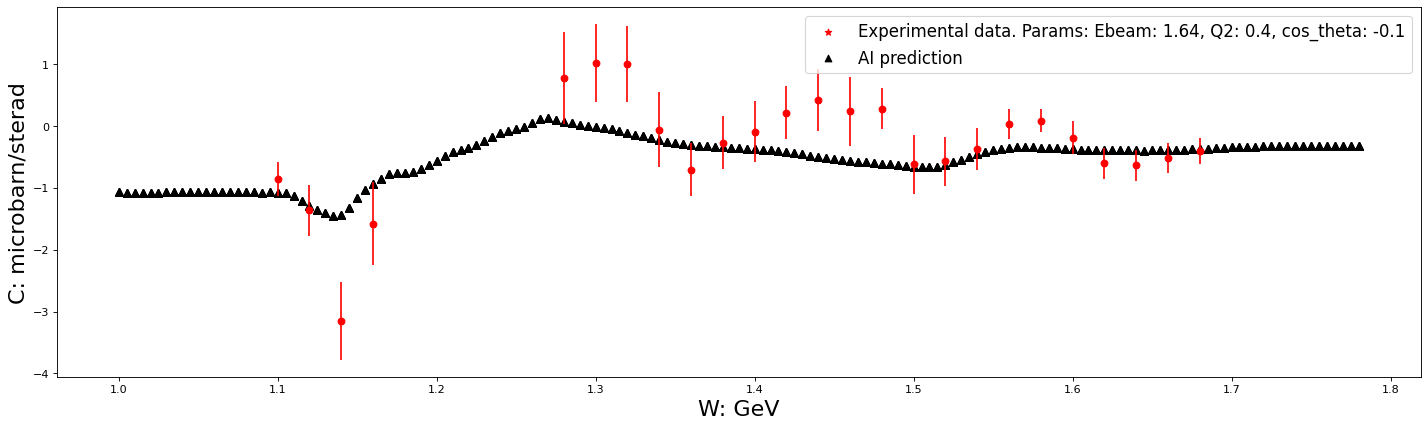

100%|██████████| 157/157 [00:09<00:00, 16.60it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-13-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7765286084162147' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-13-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.005977641226920746' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

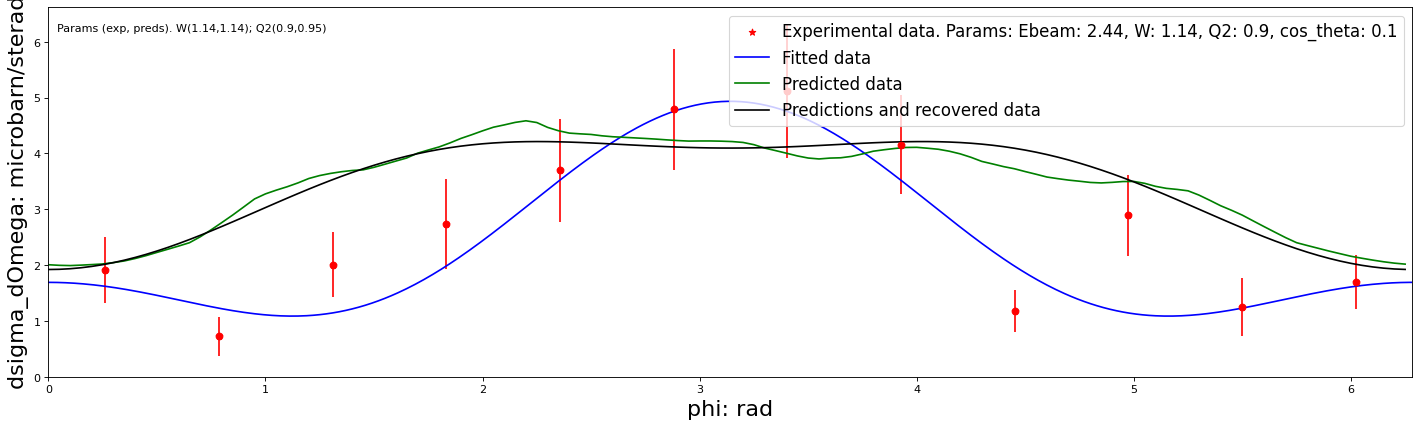

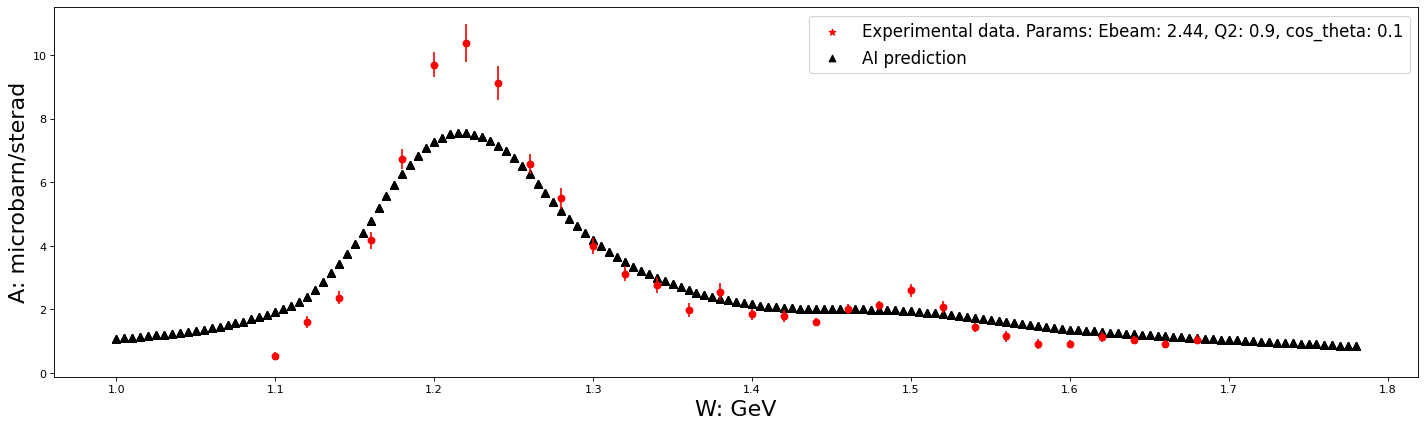

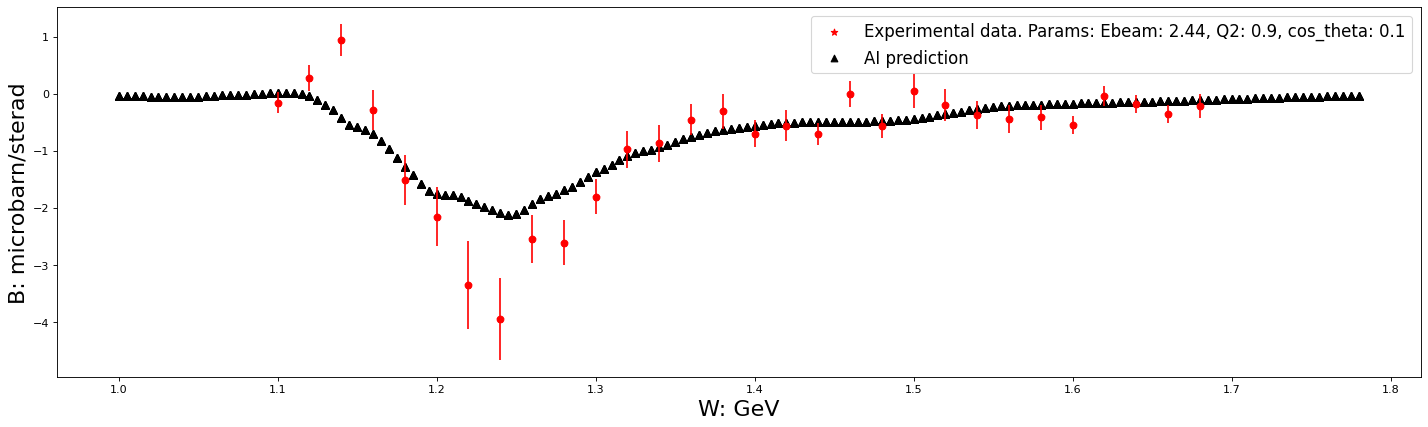

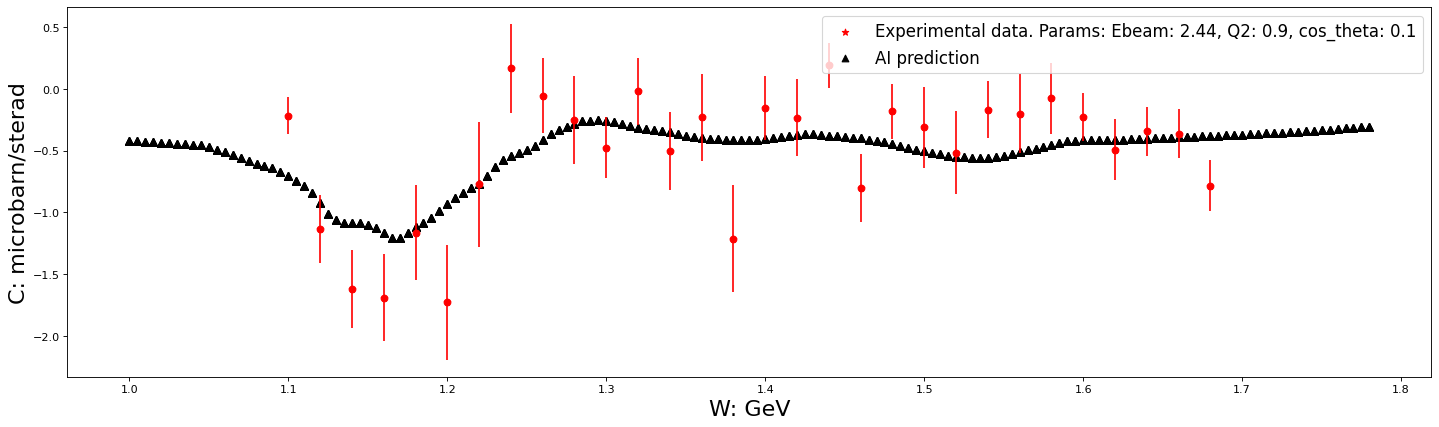

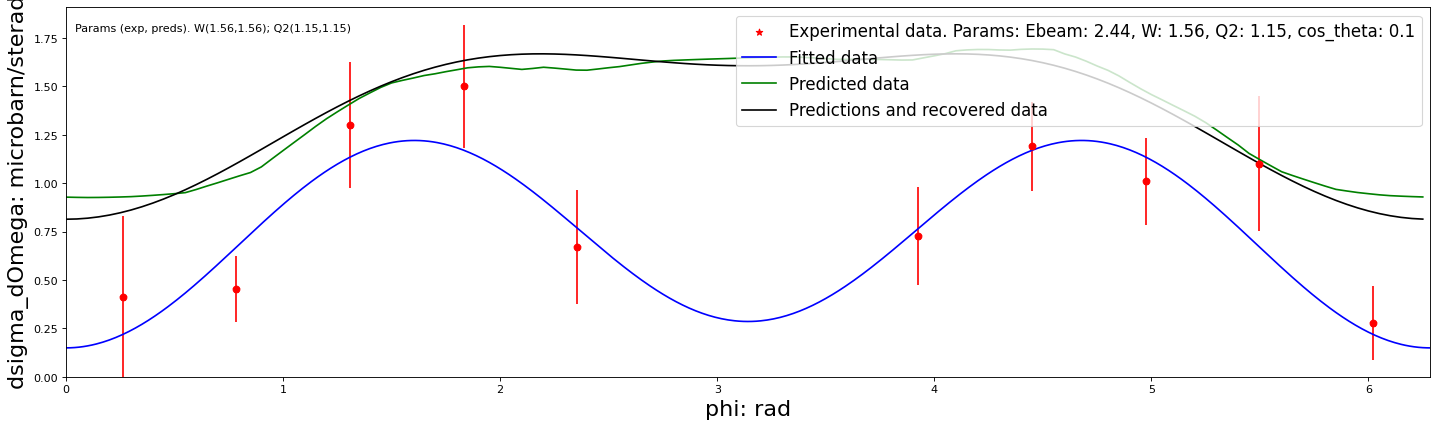

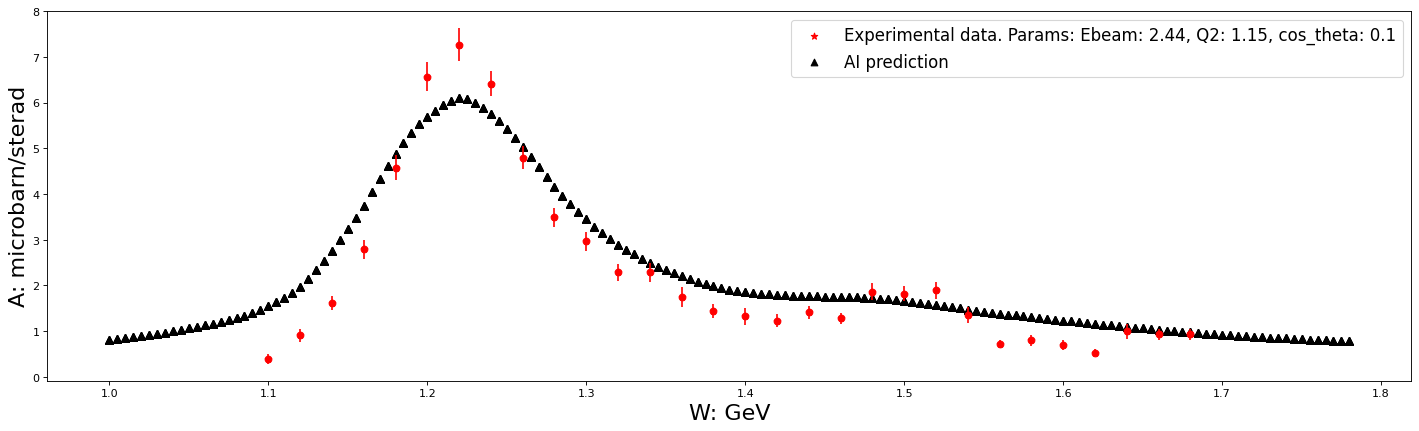

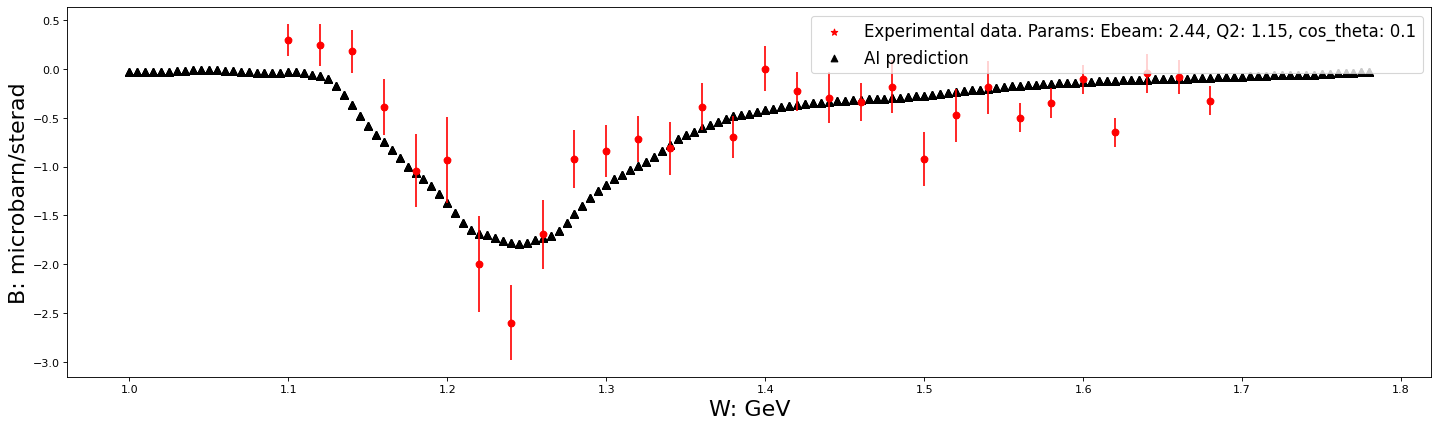

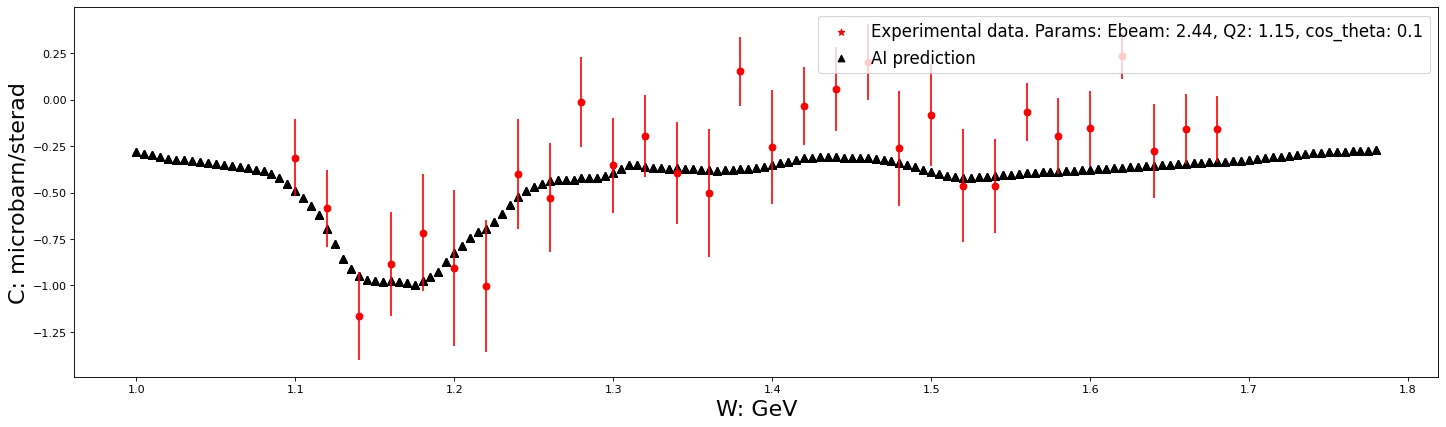

100%|██████████| 97/97 [00:10<00:00,  8.89it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/67221 [00:00<?, ?it/s]<ipython-input-13-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.007568693887646532' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-13-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.002006612238497034' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

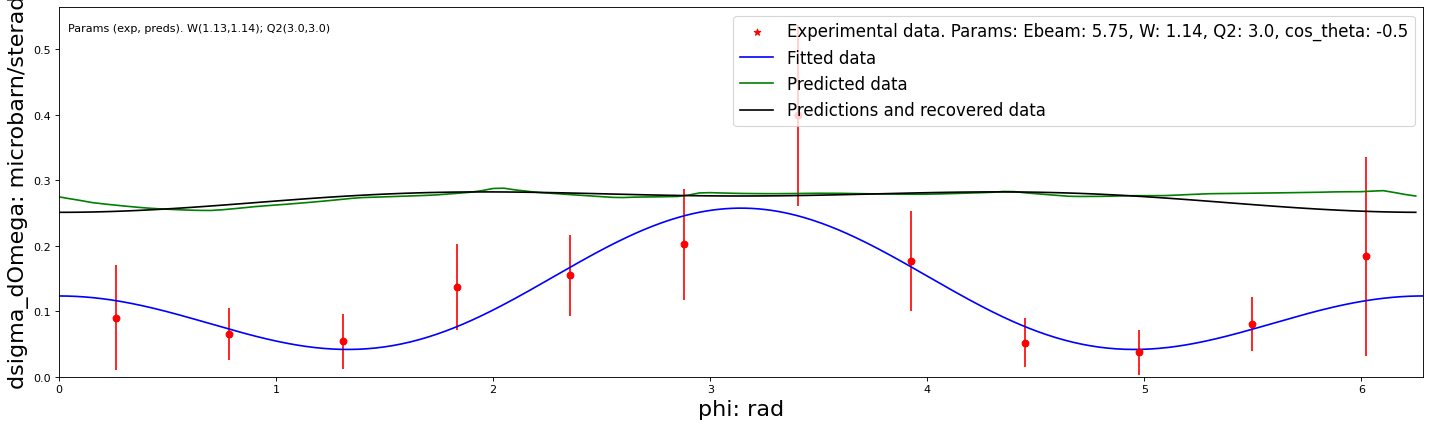

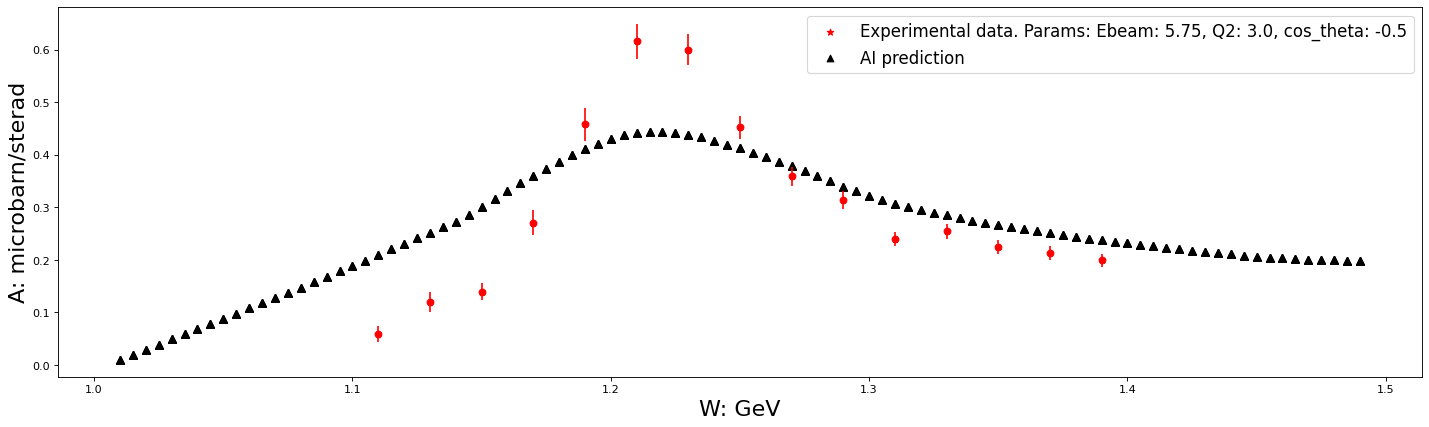

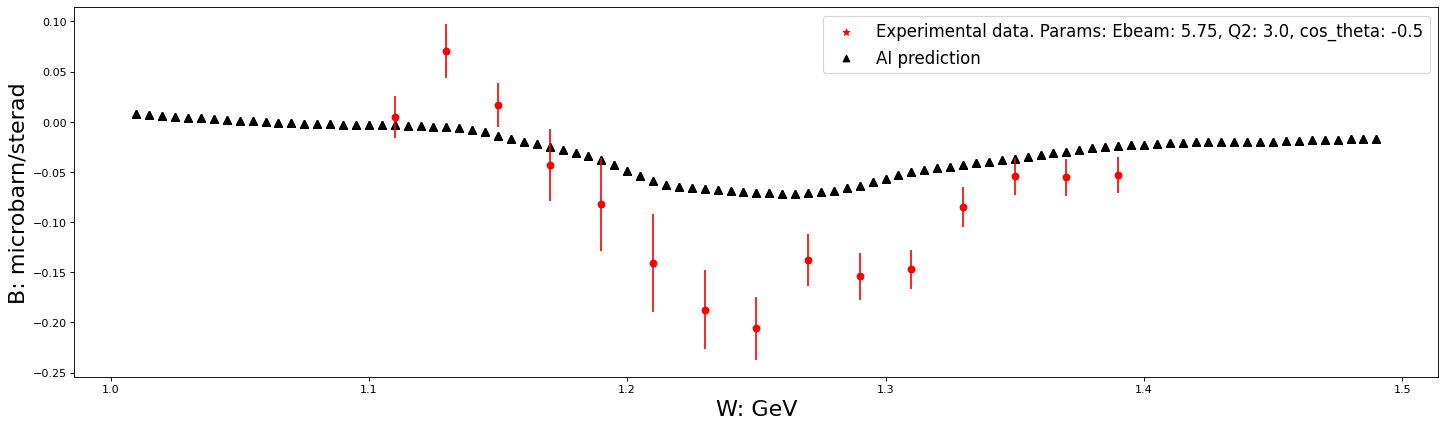

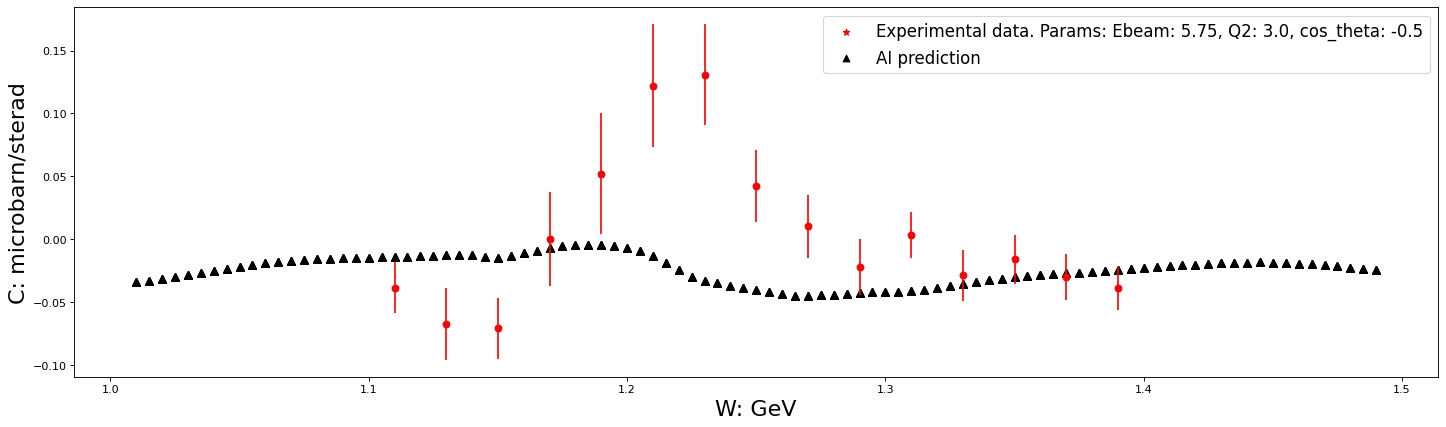

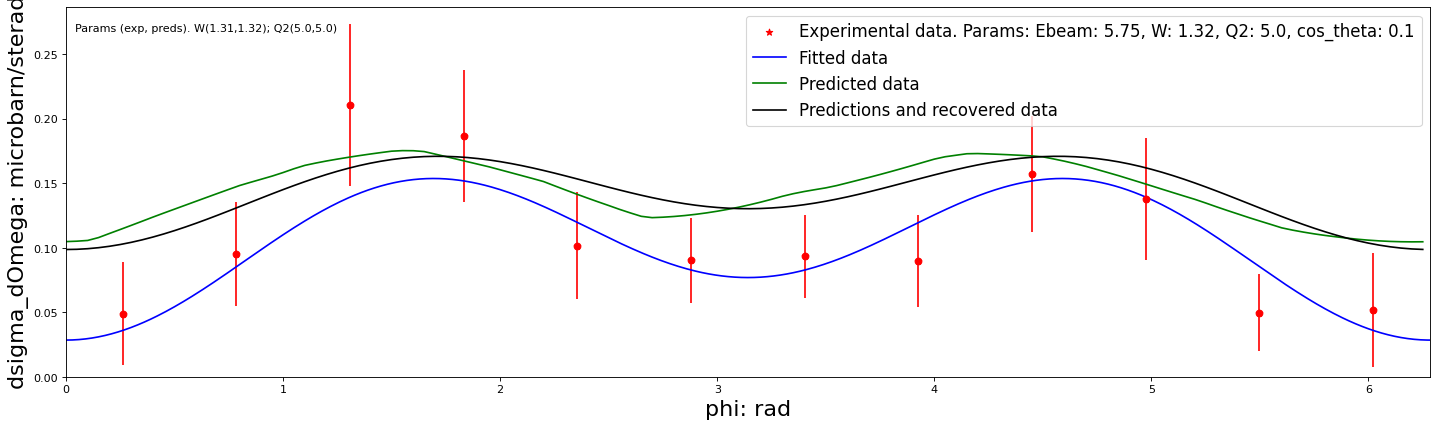

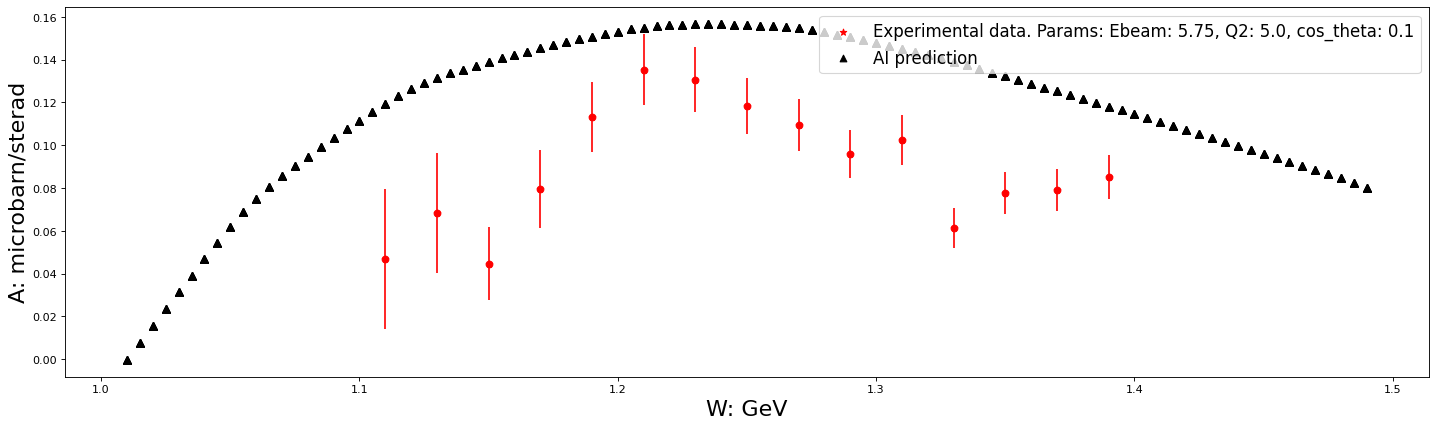

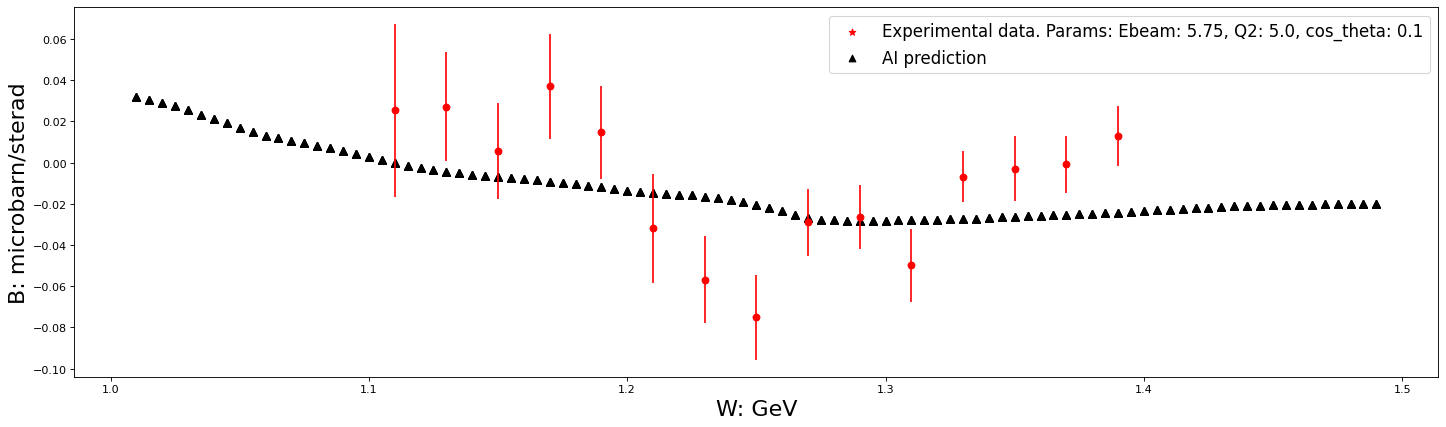

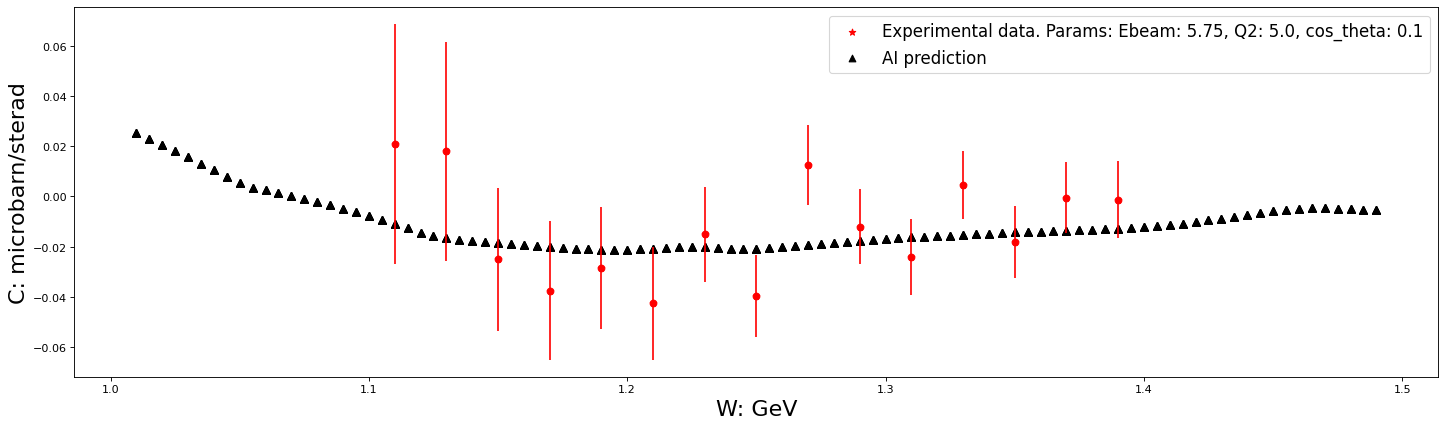

100%|██████████| 177/177 [00:05<00:00, 29.73it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/33453 [00:00<?, ?it/s]<ipython-input-13-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6997682863389343' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-13-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.011595917610405388' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

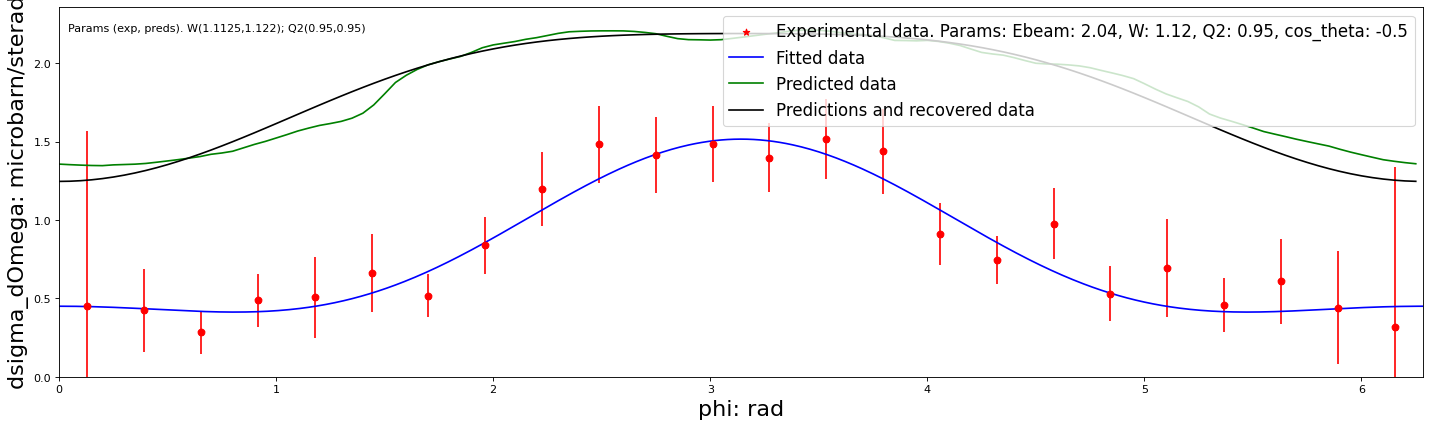

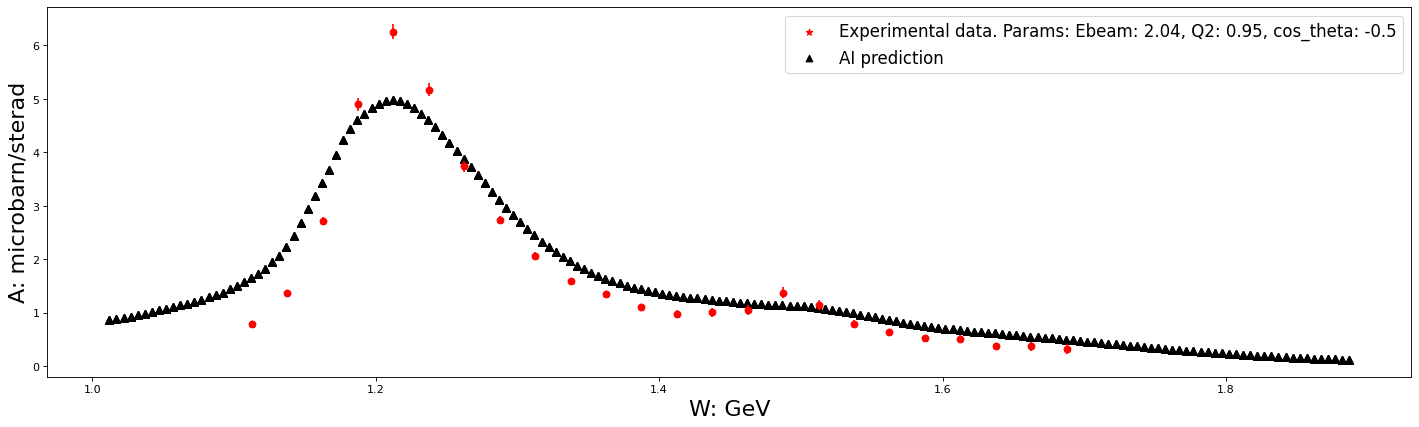

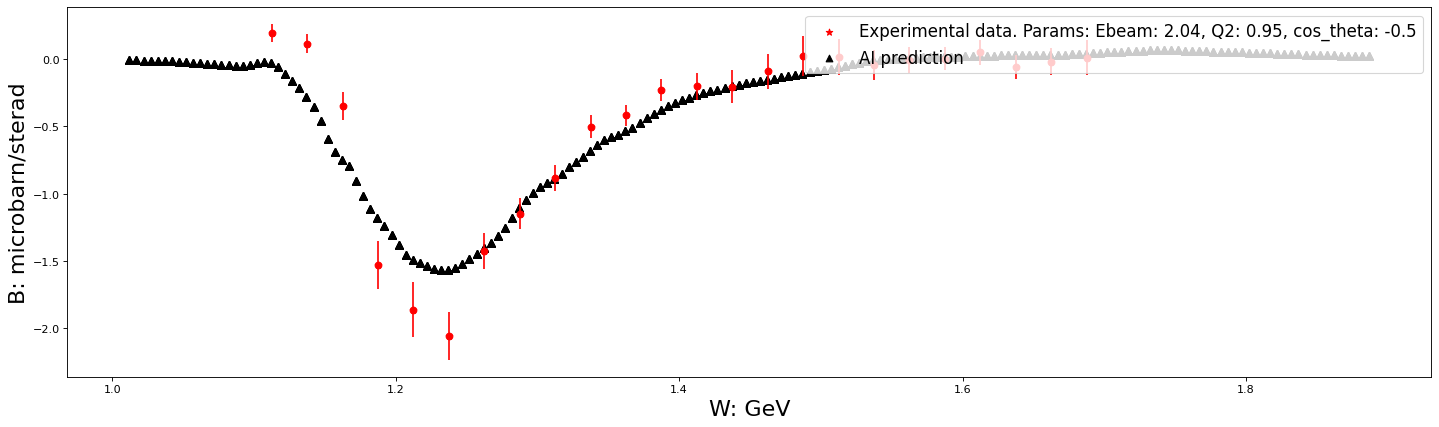

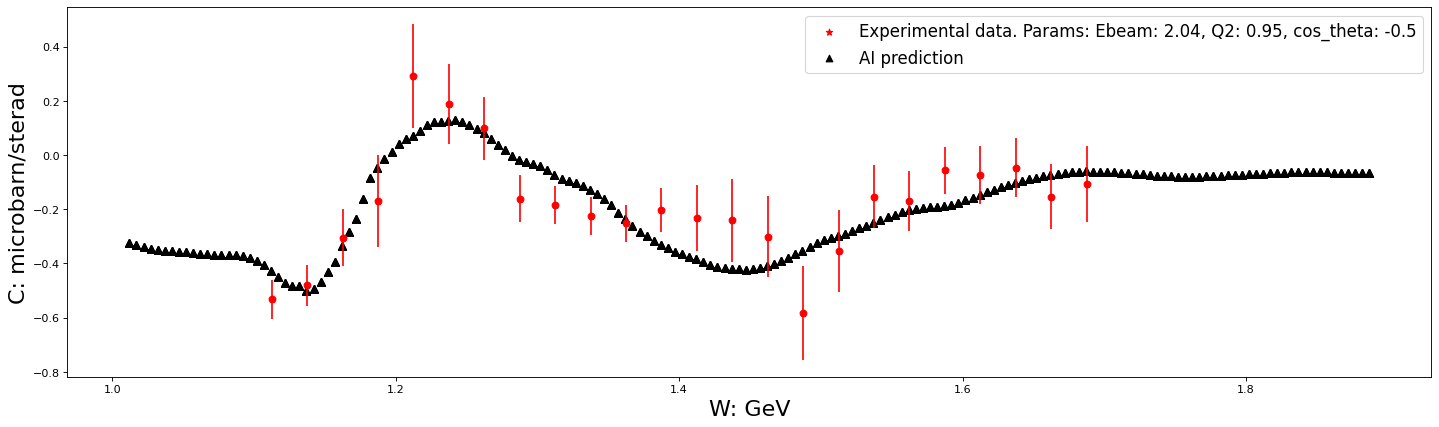

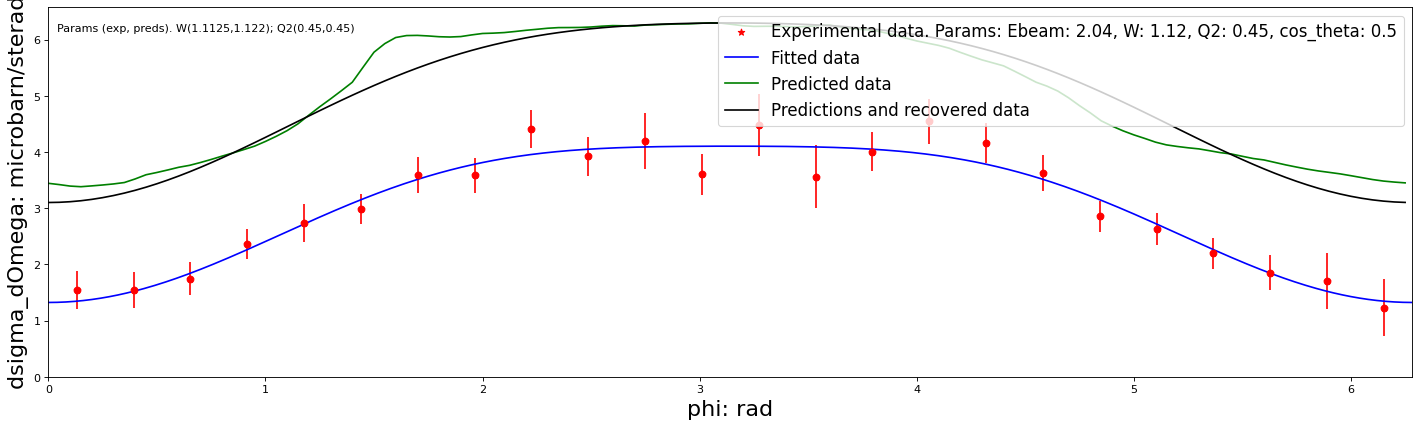

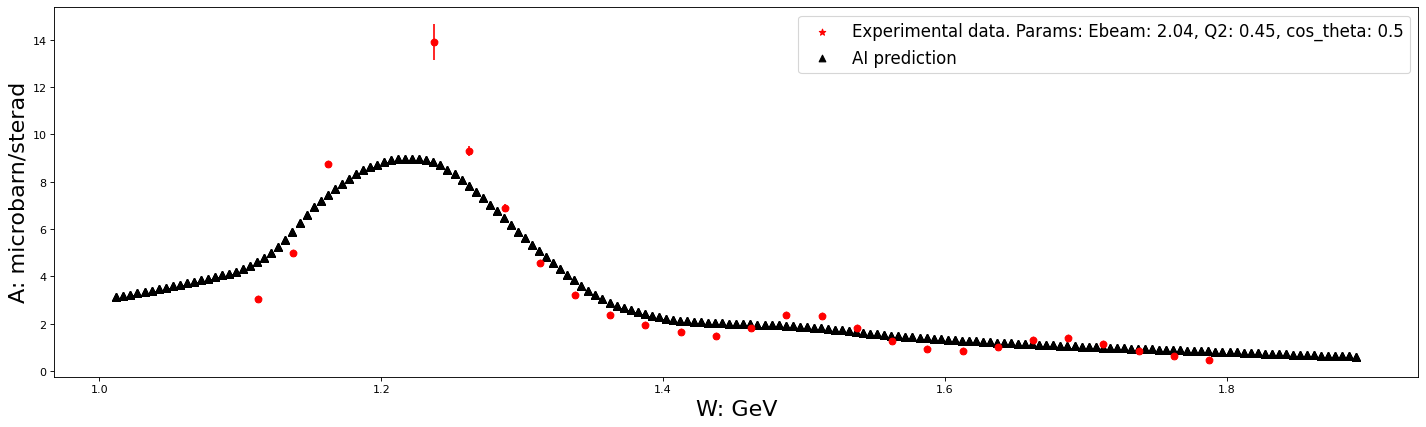

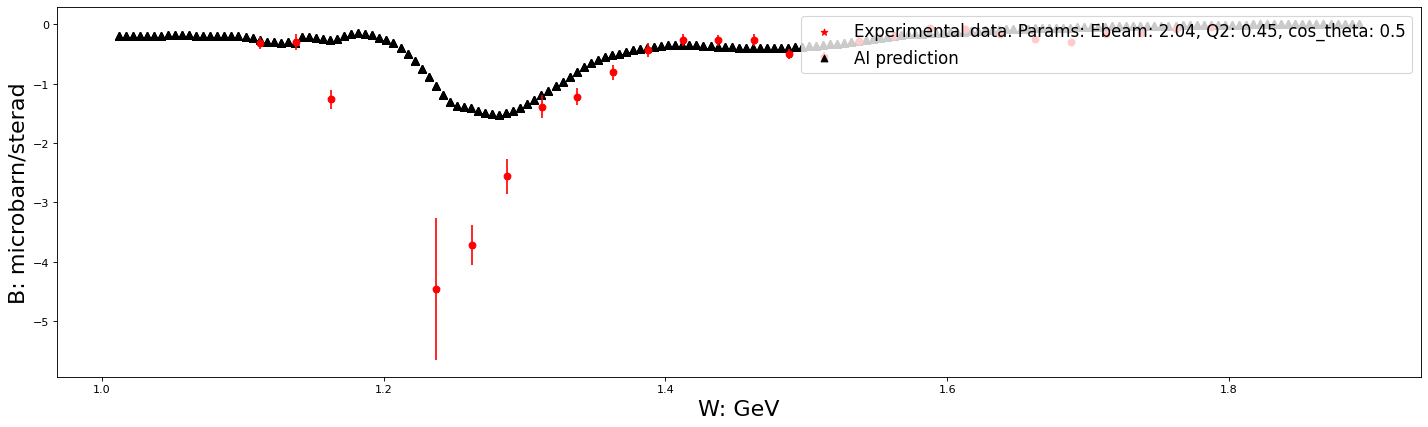

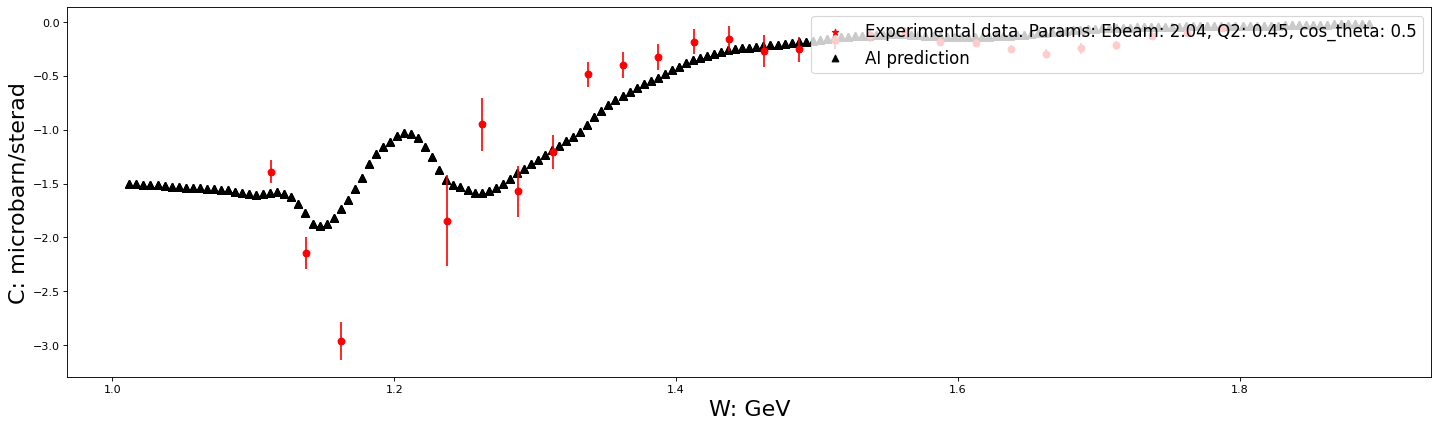

In [15]:
def plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf):
    plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
    return None

for Ebeam in [1.64, 2.44, 5.75, 2.04]:
    os.makedirs(f"/content/NN/E_beam={Ebeam}", exist_ok=True)
    df_grid = generate_grid_df(Ebeam)
    df_sf = generate_df_sf(Ebeam)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[0]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[0]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[0]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[1]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[1]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[1]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

In [16]:
# Log results to W&B Media

# for root, dirs, files in os.walk(os.path.abspath("/content/NN")):
#     for file in files:
#         path_to_img = os.path.join(root, file)
#         im = plt.imread(path_to_img)
#         wandb.log({"img": [wandb.Image(path_to_img)]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})

2025-01-02 20:26:02,742 : DEBUG : STREAM b'IHDR' 16 13
2025-01-02 20:26:02,746 : DEBUG : STREAM b'tEXt' 41 57
2025-01-02 20:26:02,748 : DEBUG : STREAM b'pHYs' 110 9
2025-01-02 20:26:02,757 : DEBUG : STREAM b'IDAT' 131 65536
2025-01-02 20:26:02,819 : DEBUG : Starting new HTTPS connection (1): api.wandb.ai:443
2025-01-02 20:26:02,856 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None
2025-01-02 20:26:02,879 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None
2025-01-02 20:26:02,888 : DEBUG : STREAM b'IHDR' 16 13
2025-01-02 20:26:02,894 : DEBUG : STREAM b'tEXt' 41 57
2025-01-02 20:26:02,897 : DEBUG : STREAM b'pHYs' 110 9
2025-01-02 20:26:02,901 : DEBUG : STREAM b'IDAT' 131 65536
2025-01-02 20:26:02,947 : DEBUG : STREAM b'IHDR' 16 13
2025-01-02 20:26:02,957 : DEBUG : STREAM b'tEXt' 41 57
2025-01-02 20:26:02,961 : DEBUG : STREAM b'pHYs' 110 9
2025-01-02 20:26:02,966 : DEBUG : STREAM b'IDAT' 131 36742
2025-01-02 20:26:03,019 : DEBUG : STREAM b'IHDR' 16 13
202

In [17]:
# Log results to W&B Artifacts

wandb_table = wandb.Table(columns=["Ebeam", "cross section","A","B","C"])


for root, dirs, files in os.walk(os.path.abspath("/content/NN//E_beam=1.64")):
    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'))

    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.04")):
    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'))

    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.44")):
    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'))

    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=5.75")):
    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'))

    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'))



# Create a wandb Artifact
artifact = wandb.Artifact(name="plots", type="data")
# Add the table to the artifact
#artifact.add(wandb.Image(path_to_img), "plots_E_beam={Ebeam}")
artifact.add(wandb_table, f"plots")
# Log the artifact
wandb.log_artifact(artifact)

2025-01-02 20:26:06,005 : DEBUG : STREAM b'IHDR' 16 13
2025-01-02 20:26:06,008 : DEBUG : STREAM b'tEXt' 41 57
2025-01-02 20:26:06,012 : DEBUG : STREAM b'pHYs' 110 9
2025-01-02 20:26:06,017 : DEBUG : STREAM b'IDAT' 131 65536
2025-01-02 20:26:06,041 : DEBUG : STREAM b'IHDR' 16 13
2025-01-02 20:26:06,042 : DEBUG : STREAM b'tEXt' 41 57
2025-01-02 20:26:06,045 : DEBUG : STREAM b'pHYs' 110 9
2025-01-02 20:26:06,048 : DEBUG : STREAM b'IDAT' 131 36742
2025-01-02 20:26:06,067 : DEBUG : STREAM b'IHDR' 16 13
2025-01-02 20:26:06,070 : DEBUG : STREAM b'tEXt' 41 57
2025-01-02 20:26:06,074 : DEBUG : STREAM b'pHYs' 110 9
2025-01-02 20:26:06,077 : DEBUG : STREAM b'IDAT' 131 35084
2025-01-02 20:26:06,095 : DEBUG : STREAM b'IHDR' 16 13
2025-01-02 20:26:06,097 : DEBUG : STREAM b'tEXt' 41 57
2025-01-02 20:26:06,100 : DEBUG : STREAM b'pHYs' 110 9
2025-01-02 20:26:06,102 : DEBUG : STREAM b'IDAT' 131 34502
2025-01-02 20:26:06,122 : DEBUG : STREAM b'IHDR' 16 13
2025-01-02 20:26:06,125 : DEBUG : STREAM b'tEXt' 

<Artifact plots>

In [18]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr_scheduler_monitoring,████████▄▄▄▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,█▇▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▇▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▇▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▁▅▆▇▇▇▇▇▇▇▇▇▇██████████████████████████
train_rmse,█▇▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▇▅▂▄▂▂▄▃▂▂▂▂▂▃▂▂▁▂▁▂▁▂▁▂▂▂▂▁▂▁▁▂▂▂▂▁▁▁▂
val_mae,██▄▃▄▂▂▃▂▂▂▂▂▂▅▂▁▂▁▁▂▁▂▁▁▂▁▂▁▁▂▁▁▁▂▁▂▁▁▂
val_mse,█▆▄▂▄▂▂▄▃▂▂▂▂▂▃▂▂▁▂▁▁▁▂▁▂▂▂▂▁▂▁▁▂▂▂▂▁▁▁▂


In [ ]:
# #for random choice cross sections and structure functions
# os.makedirs(f"/content/NN/cross_sections", exist_ok=True)
# os.makedirs(f"/content/NN/structure_functions", exist_ok=True)
# for Ebeam in [1.64, 2.44, 5.75, 2.04]:
#     df_grid = generate_grid_df(Ebeam)
#     df_sf = generate_df_sf(Ebeam)
#     step = 0
#     while step != 2:
#         picture_is_not_drawn = True
#         while picture_is_not_drawn:
#             Q2 = random.choice(df[df.Ebeam==Ebeam].Q2.unique())
#             W = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2)].W.unique())
#             cos_theta = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2) & (df.W==W)].cos_theta.unique())
#             try:
#                 plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
#             except:
#                 print(Ebeam, W, Q2, cos_theta)
#             else:
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
#                 step += 1
#                 picture_is_not_drawn = False